# pyBumpHunter Example

Simple notebook for testing the pyBumpHunter.py package.

We will use histograms ranging between 0 and 20 with 60 even bins.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyBumpHunter as BH
from datetime import datetime  ## Used to compute the execution time
import uproot as upr  ## Used to read data from a root file

## Load input file

The data (in a ROOT file format) consists of three histograms: a steeply falling 'background' distribution in a [0,20] x-axis range, a 'signal' gaussian shape centered on a value of 5.5, and a 'data' distribution sampled from background and signal distributions, with a signal fraction of 0.15%.


In [2]:
# Open the file
File = upr.open('../data/data.root')
File.items()

# Background
bkg = File['bkg'].arrays(library='np')['bkg']

# Data
data = File['data'].arrays(library='np')['data']

# Signal
sig = File['sig'].arrays(library='np')['sig']

# Position of the bump in the data
Lth = 5.5

# Range for the histogram
rang = [0,20]

In [3]:
bkg.shape

(99996,)

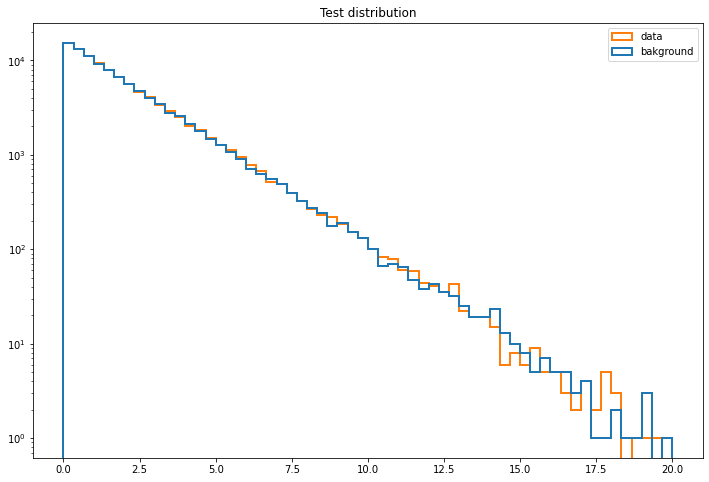

In [4]:
# Plot the 2 distributions (data and background)
F = plt.figure(figsize=(12,8))
plt.title('Test distribution')
plt.hist((bkg,data),bins=60,histtype='step',range=rang,label=('bakground','data'),linewidth=2,log=True)
plt.legend()
plt.show()

## Create a BumpHunter1D class instance.

The BumpHunte1Dr class provides all the methods required to "bump hunt" in ease.

All the parameters and results are also stored in this object.

In [5]:
hunter = BH.BumpHunter1D(
    rang=rang,
    width_min=2,
    width_max=6,
    width_step=1,
    scan_step=1,
    npe=10000,
    nworker=1,
    seed=666,
)

## Call the BumpScan Method

The function will scan the data distribution using variable-width window sizes (between width_min and width_max) and calculate the p-value of data with respect to the background for each window. The minimum p-value obtained from all windows is the local p-value.

To cope with the look-elsewhere effect a global p-value is calculated using a two-step procedure:
- the distribution of possible p-values is determined from background-only pseudo-experiments (npe parameter)
- the p-value found in data is compared to the background-only p-value distribution to calculate the global p-value

In [6]:
print('####bump_scan call####')
begin = datetime.now()
hunter.bump_scan(data,bkg)
end = datetime.now()
print(f'time={end - begin}')
print('')

####bump_scan call####
Generating histograms
5 values of width will be tested
SCAN
Global p-value : 0.0177  (177 / 10000)
Significance = 2.10375

time=0:00:19.544294



## Print results of BH scan

Print information on more significant window ("bump"): location, width, excess over background events, global p-value and global significance.

In [7]:
print(hunter.bump_info(data))
print(f'   mean (true) = {Lth}')

Bump edges : [5.33, 6.67]  (loc=16, width=4)
Bump mean | width : 6 | 1.33
Evaluated number of signal events : 208
Local p-value | test statistic : 0.00017341 | 8.6598
Local significance : 3.5776
Global p-value : 0.0177
Global significace : 2.1
   mean (true) = 5.5


## Tomography plot

This figure shows the p-value in each of the windows used to scan the data distribution.

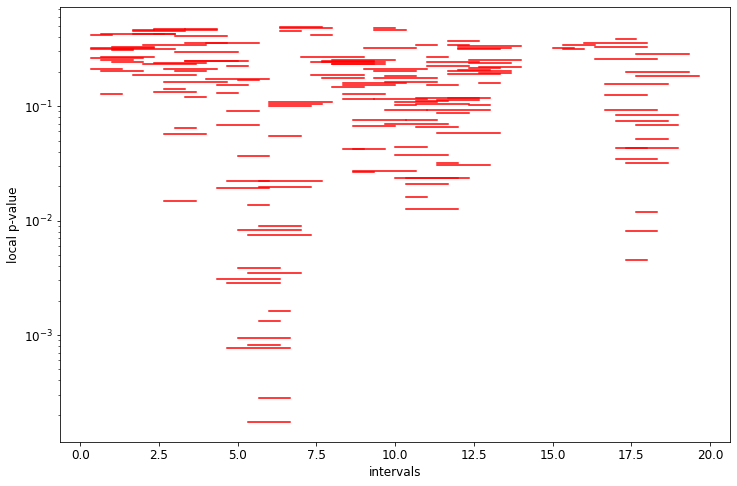

In [8]:
hunter.plot_tomography(data)

## Show most significant window

Window with the lowest p-value obtained from the data scans.

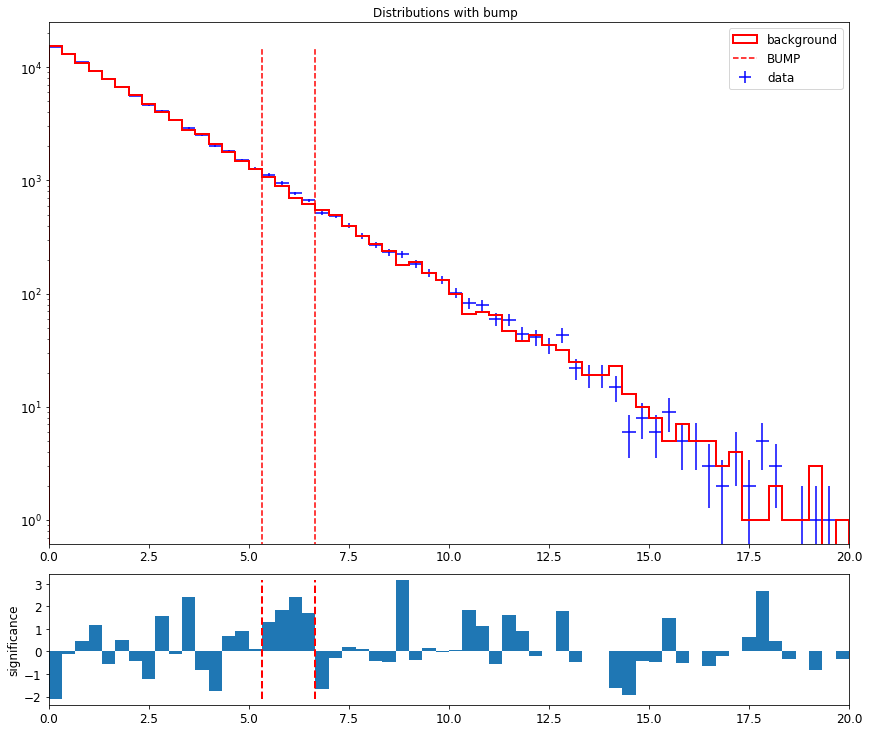

In [9]:
hunter.plot_bump(data,bkg)

# Global p-value

This figure shows the test statistics (log(p-value)) obtained from background-only toys and the p-value obtained from data. The global p-value is equal to the fraction of background-only experiments whch have a higher test statistics than for the data (i.e this is the p-value of p-values).

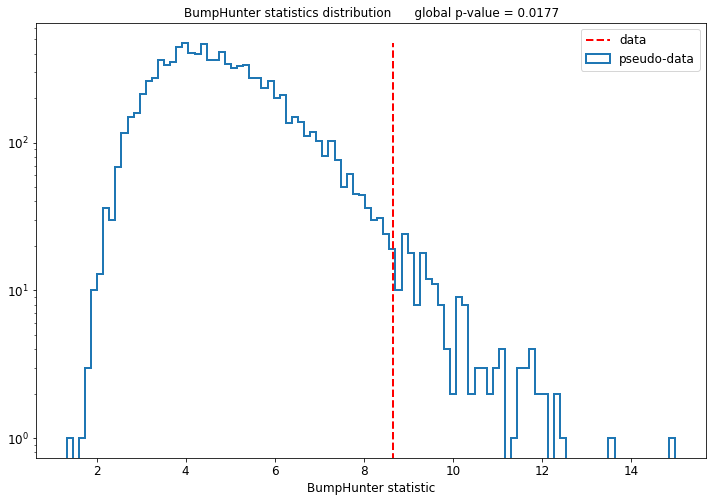

In [10]:
hunter.plot_stat(show_Pval=True)

## Signal injection

Inject signal in data until a 5 sigma excess is found. 

In [11]:
# We have to set additionnal parameters specific to the signal injection.
# All the parameters defined previously are kept.
hunter.sigma_limit = 5
hunter.str_min = -1 # if str_scale='log', the real starting value is 10**str_min
hunter.str_scale = 'log'
hunter.signal_exp = 150 # Correspond the the real number of signal events generated when making the data

print('####singal_inject call####')
begin = datetime.now()
hunter.signal_inject(sig,bkg,is_hist=False)
end = datetime.now()
print(f'time={end - begin}')
print('')

####singal_inject call####
Generating background only histograms
5 values of width will be tested
BACKGROUND ONLY SCAN
STARTING INJECTION
   STEP 1 : signal strength = 0.1
Generating background+signal histograms
BACKGROUND+SIGNAL SCAN
Global p-value : 0.0495  (495 / 10000)   0.0836  (836)   0.0152  (152)
Significance = 1.64972 (1.38126  2.16484)

   STEP 2 : signal strength = 0.2
Generating background+signal histograms
BACKGROUND+SIGNAL SCAN
Global p-value : 0.0464  (464 / 10000)   0.0809  (809)   0.0146  (146)
Significance = 1.68081 (1.39904  2.18078)

   STEP 3 : signal strength = 0.30000000000000004
Generating background+signal histograms
BACKGROUND+SIGNAL SCAN
Global p-value : 0.0433  (433 / 10000)   0.0789  (789)   0.0131  (131)
Significance = 1.71361 (1.41251  2.22323)

   STEP 4 : signal strength = 0.4
Generating background+signal histograms
BACKGROUND+SIGNAL SCAN
Global p-value : 0.0408  (408 / 10000)   0.0765  (765)   0.0119  (119)
Significance = 1.74148 (1.42901  2.26034)

  

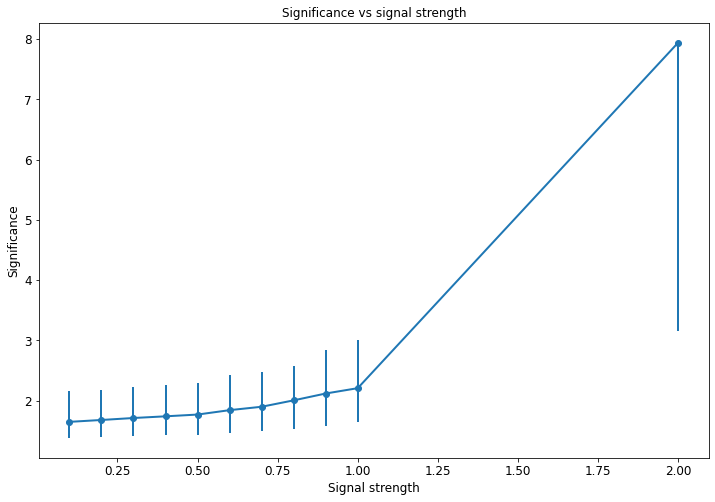

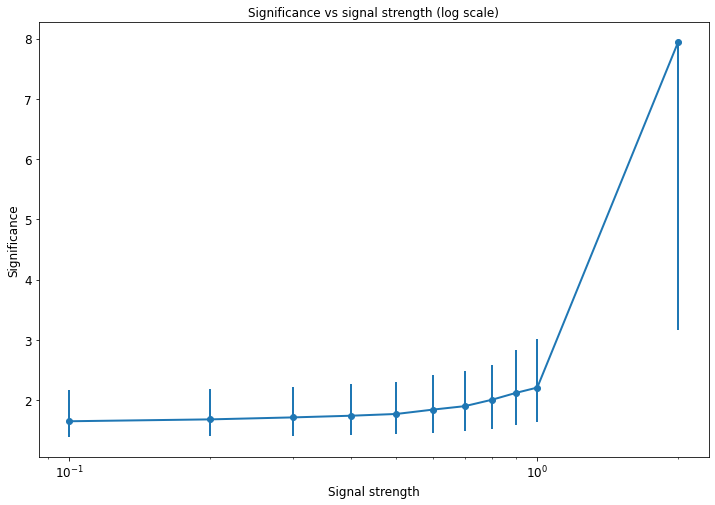

In [12]:
# Get the injection plot (with linear and log scale axis)
hunter.plot_inject()